In [25]:
import os
os.chdir('../../advanced_programming_teaching/seminar_1')
import pandas as pd
from utils.helper_functions import save_pickle, load_pickle
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
import time
import copy
import torch.utils.data as Data
import torch
import torch.nn as nn
import torch.nn.functional as F

class RegressionColumnarDataset(Data.Dataset):
    """
    Object Dataset in PyTorch to store dataset before loading into DataLoader
    """
    def __init__(self, df_transformed, target):
        self.data = df_transformed.copy().values.astype(np.float32)
        # Select target
        self.target = target.values.astype(np.float32)
        self.n_feature = self.data.shape[1]

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return [self.data[idx], self.target[idx]]

def setup_dataloader(df, mapper, batch_size=256, shuffle=True, num_workers=0):
    """
    Convert preprocessed DataFrame (with target column 'price') into DataLoader
    """
    df_transformed = mapper.transform(df)
    target = df['price'].copy() / 1e6
    df_dataset = RegressionColumnarDataset(df_transformed, target)
    dataloader = Data.DataLoader(df_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0)
    return dataloader

def to_numpy(tensor):
    """
    Convert a Pytorch tensor to numpy
    """
    return tensor.cpu().data.numpy()

# Prepare data

In [43]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
mapper = load_pickle('model/mapper.pkl')

traindl = setup_dataloader(train, mapper)
testdl = setup_dataloader(test, mapper)

# Neural Network Level 1

In [46]:
# Weight initial
def customize_weight_init(x):
    """
    Use Xavier method to initialize weight
    """
    classname = x.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.xavier_normal_(x.weight)
        nn.init.constant_(x.bias, 0)
        
    if classname.find('BatchNorm') != -1:
        nn.init.constant_(x.weight, 1)
        nn.init.constant_(x.bias, 0)
        
# Define model
class NNet_model_1(nn.Module):
    def __init__(self, input_dim, layer1, layer2, n_output=1):
        '''
        A class that defines the neural network structure
        
        Params:
        input_dim: number of features from the dataset
        layer1 : num of neurons in layer 1
        layer2: num of neurons in layer 2
        
        output: 
        an object that holds the model structure (can be called as a function)
        '''
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, layer1),
            nn.ReLU(),
            nn.BatchNorm1d(layer1),
            nn.Dropout(0.3),
            
            nn.Linear(layer1, layer2),
            nn.ReLU(),
            nn.BatchNorm1d(layer2),
            nn.Dropout(0.3),
            
            nn.Linear(layer2, n_output)
        )
        
    def forward(self, x):
        return self.network(x)

In [47]:
model = NNet_model_1(traindl.dataset.n_feature, 128, 32)
model.apply(customize_weight_init)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay= 0.1)
loss_function = nn.MSELoss(reduce='mean')

In [50]:
def train_loop(traindl, testdl, model, optimizer, loss_function, 
               seed=0, epoches=5, save_folder='model', verbose=True):

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    if verbose: print('Training on: ', device)
    torch.manual_seed(seed)
    
    # Some setup
    start_time = time.time()
    
    for epoch in range(epoches): 
        # Tracking loss
        train_loss = np.array([])
        test_loss = np.array([])
        
        # Train
        model.train()
        for x, y in iter(traindl):
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            yhat = model(x).to(device)
            loss = loss_function(yhat, y)
            loss.backward()
            optimizer.step()
            
            # Track train loss
            train_loss  = np.concatenate((train_loss, loss.item()), axis=None)
        
        # Evaluate
        model.eval()
        for x, y in iter(testdl):
            x, y = x.to(device), y.to(device)
            
            yhat = model(x).to(device)
            loss = loss_function(yhat, y)
            
            # Track train loss
            test_loss  = np.concatenate((test_loss, loss.item()), axis=None)
            
        if verbose:
            cur_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch {epoch+1}: train_loss: {train_loss.mean():.4f} test_loss: {test_loss.mean():.4f}')

        checkpoint = {
            'model': model,
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'test_loss': test_loss.mean(),
            'train_loss': train_loss.mean()
        }
        path_checkpoint = save_folder + '/nnet_1.pth'
        torch.save(checkpoint, path_checkpoint)

    if verbose:
        print(f"Finished training in {time.time() - start_time:.4f} seconds")
        print(f'Model save to {path_checkpoint}')

In [51]:
train_loop(traindl, testdl, model, optimizer, loss_function)

Training on:  cpu
Epoch 1: train_loss: 0.5924 test_loss: 0.1660
Epoch 2: train_loss: 0.1570 test_loss: 0.1399
Epoch 3: train_loss: 0.1372 test_loss: 0.1388
Epoch 4: train_loss: 0.1364 test_loss: 0.1358
Epoch 5: train_loss: 0.1337 test_loss: 0.1363
Finished training in 4.4986 seconds
Model save to model/nnet_1.pth


# Neural Network Level 2

In [21]:
# Define model
# Define model
class NNet_model_2(nn.Module):
    def __init__(self, input_dim, layer1, layer2, n_output=1):
        '''
        A class that defines the neural network structure
        
        Params:
        input_dim: number of features from the dataset
        layer1 : num of neurons in layer 1
        layer2: num of neurons in layer 2
        
        output: 
        an object that holds the model structure (can be called as a function)
        '''
        super().__init__()
        self.input_dim = input_dim
        self.ln1 = nn.Linear(self.input_dim, layer1)
        self.ln2 = nn.Linear(layer1, layer2)
        self.ln3 = nn.Linear(layer2, n_output)
        self.bn1 = nn.BatchNorm1d(layer1)
        self.bn2 = nn.BatchNorm1d(layer2)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        # Feed-foward to Layer 1
        x = self.dropout(self.bn1(F.relu(self.ln1(x))))
        # Feed forward to Layer 2
        x = self.dropout(self.bn2(F.relu(self.ln2(x))))
        # Output
        x = self.ln3(x)
        return x

In [22]:
model = NNet_model_2(traindl.dataset.n_feature, 128, 32)
model.apply(customize_weight_init)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay= 0.1)
loss_function = nn.MSELoss(reduce='mean')

In [36]:
def train_loop_2(traindl, testdl, model, optimizer, loss_function, 
                seed=0, epoches=5, save_folder='model', verbose=True):

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    if verbose: print('Training on: ', device)
    torch.manual_seed(seed)
    
    # Some setup
    start_time = time.time()
    df = pd.DataFrame(columns = ['train', 'test'])
    
    for epoch in range(epoches): 
        # Tracking loss
        train_loss = np.array([])
        test_loss = np.array([])
        
        # Train
        model.train()
        for x, y in iter(traindl):
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            yhat = model(x).to(device)
            loss = loss_function(yhat, y)
            loss.backward()
            optimizer.step()
            
            # Track train loss
            train_loss  = np.concatenate((train_loss, loss.item()), axis=None)
        
        # Evaluate
        model.eval()
        for x, y in iter(testdl):
            x, y = x.to(device), y.to(device)
            
            yhat = model(x).to(device)
            loss = loss_function(yhat, y)
            
            # Track test loss
            test_loss  = np.concatenate((test_loss, loss.item()), axis=None)

        if verbose:
            cur_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch {epoch+1}: train_loss: {train_loss.mean():.4f} test_loss: {test_loss.mean():.4f}')
            
        # After each epoch, append train and test loss mean
        df = df.append({
            'train' : train_loss.mean(),
            'test' : test_loss.mean()
        }, ignore_index=True)
        
        # Save best model
        errors = df['test'].values
        if errors[-1] == min(errors):
            best_model = copy.deepcopy(model)
            best_epoch = epoch
            best_optimizer = copy.deepcopy(optimizer)
            checkpoint = {
                'model': model,
                'epoch': epoch + 1,
                'state_dict': best_model.state_dict(),
                'optimizer': best_optimizer.state_dict(),
                'test_loss': test_loss.mean(),
                'train_loss': train_loss.mean()
            }
            path_checkpoint = save_folder + '/nnet_1.pth'
            torch.save(checkpoint, path_checkpoint)

    if verbose:
        print(f"Finished training in {time.time() - start_time:.4f} seconds")
        print(f'Model save to {path_checkpoint}')
        print('Save dataframe tracking loss at data/track_loss.csv')
        df.to_csv('data/track_loss.csv', index=False)

In [41]:
train_loop_2(traindl, testdl, model, optimizer, loss_function, epoches=15)

Training on:  cpu
Epoch 1: train_loss: 0.1346 test_loss: 0.1386
Epoch 2: train_loss: 0.1341 test_loss: 0.1356
Epoch 3: train_loss: 0.1341 test_loss: 0.1382
Epoch 4: train_loss: 0.1363 test_loss: 0.1358
Epoch 5: train_loss: 0.1337 test_loss: 0.1364
Epoch 6: train_loss: 0.1391 test_loss: 0.1448
Epoch 7: train_loss: 0.1344 test_loss: 0.1356
Epoch 8: train_loss: 0.1376 test_loss: 0.1361
Epoch 9: train_loss: 0.1346 test_loss: 0.1364
Epoch 10: train_loss: 0.1349 test_loss: 0.1360
Epoch 11: train_loss: 0.1350 test_loss: 0.1405
Epoch 12: train_loss: 0.1341 test_loss: 0.1396
Epoch 13: train_loss: 0.1346 test_loss: 0.1378
Epoch 14: train_loss: 0.1340 test_loss: 0.1372
Epoch 15: train_loss: 0.1335 test_loss: 0.1410
Finished training in 16.3148 seconds
Model save to model/nnet_1.pth
Save dataframe tracking loss at data/track_loss.csv


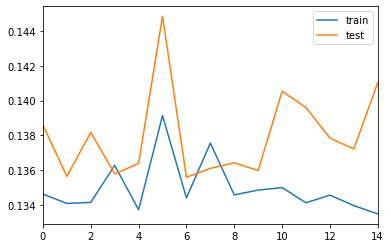

In [42]:
track_loss = pd.read_csv('data/track_loss.csv')
track_loss.plot()